In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#LogRegression
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score



def AddBinaryString(df,ListOfStrings):
    for string in ListOfStrings:
        if string != '-':
            dfJobs['Contains_'+string] = dfJobs['job_title_full'].str.find(string)
            dfJobs['Contains_'+string] = np.where(dfJobs['Contains_'+string]>-1.,1,0)
    return(df)

In [2]:
dfUser         = pd.read_csv("../applicant_material/user.csv") 
dfJobs         = pd.read_csv("../applicant_material/job_desc.csv") 

## Clean and prepare data

In [3]:
##Delete strings in user_id and create concat the two dataframes
dfUser.user_id = dfUser.user_id.apply(lambda x : int(x[1:]))
dfJobs.user_id = dfJobs.user_id.apply(lambda x : int(x[1:]))
dfAll          = pd.concat([dfUser, dfJobs], axis=1)

dfJobs.job_title_full = dfJobs.job_title_full.str.replace('(', ' ')
dfJobs.job_title_full = dfJobs.job_title_full.str.replace(')', ' ')
dfJobs.job_title_full = dfJobs.job_title_full.str.lower();

In [11]:
#Categorize data

##DataFrame jobs - Categorize! IfSalary
dfJobs['Salary_Bool']  = np.where(dfJobs.salary.notnull(), 1, 0)

#Keywords in Jobdescr.
#ListOfStrings = ['Manager','Junior','Senior', 'Lead', 'Remote', 'm/f']
#dfJobs        = AddBinaryString(dfJobs,ListOfStrings)
#dfJobs['GenderRemark'] = dfJobs['job_title_full'].str.find('M/F')
#dfJobs['GenderRemark'] = np.where(dfJobs['GenderRemark']>-1.,1,0)

#Keywords
ListOfMostCommonWords = Counter(" ".join(dfJobs["job_title_full"]).split()).most_common(15)
ListOfStrings         = [entry for entry, count in ListOfMostCommonWords if count > 100]
#ListOfStrings            = ['Manager','Junior','Senior', 'Lead', 'Remote', 'M/F', 'Backend','Analyst']
dfJobs                = AddBinaryString(dfJobs,ListOfStrings)

##Categorize Companies and/or job_descr
dfJobsDummies         = pd.get_dummies(dfJobs, columns=['company'])  
#dfJobsDummies = dfJobs
dfJobsDummies.columns    

Index(['job_title_full', 'salary', 'user_id', 'Salary_Bool',
       'Contains_manager', 'Contains_m/f/d', 'Contains_junior',
       'Contains_senior', 'Contains_lead', 'Contains_marketing',
       'Contains_new', 'Contains_ventures', 'Contains_remote', 'Contains_data',
       'Contains_engineer', 'Contains_product', 'Contains_pricing',
       'Contains_analyst', 'company_a', 'company_b', 'company_c', 'company_d',
       'company_e', 'company_f', 'company_g', 'company_h'],
      dtype='object')

### Select features

In [5]:
##Select features
#features     = dfUser.drop(['has_applied', 'user_id',], axis = 1)
#features.reset_index()
#features     = features.iloc[:,:]
#featureName  = 'UserFeatures'

#dfJobs       = dfAll.apply(lambda x: x.fillna(x.mean()),axis=0)
#features     = dfJobsDummies.drop(['job_title_full', 'salary','user_id',],axis = 1)
#featureName  = 'JobFeatures_Companies_Grouped_GenderRemark_SalaryBinary'          

features      = pd.concat([ dfJobsDummies.drop(['job_title_full', 'salary','user_id',],axis = 1), 
                         dfUser.drop(['has_applied','user_id'],axis =1)], axis=1)
#featureName  = 'Fvall_keywords_comp_salarybool'          
featureName   = 'FullFeature'
#featureName  = 'FullFeature_inclNaNValues'

#features     = dfJobsDummies.drop(['user_id','job_title_full','salary'],axis = 1)
#featureName  = 'JobsKeywords10' 
print(list(features.columns))

['Salary_Bool', 'Contains_manager', 'Contains_m/f/d', 'Contains_junior', 'Contains_senior', 'Contains_lead', 'Contains_marketing', 'Contains_new', 'Contains_ventures', 'Contains_remote', 'Contains_data', 'Contains_engineer', 'Contains_product', 'Contains_pricing', 'Contains_analyst', 'company_a', 'company_b', 'company_c', 'company_d', 'company_e', 'company_f', 'company_g', 'company_h', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v5', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8', 'v9']


In [6]:
#Features and target variable
X, y = features, dfUser.has_applied

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)

trainX = trainX.fillna(trainX.mean())
testX  = testX.fillna(testX.mean());

## Logistic regression  

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.607
RMSE: 0.663325
Accuracy: 56.00%


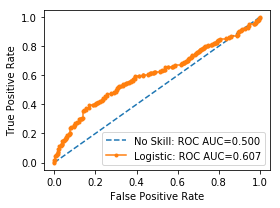

In [7]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model    = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)


preds = model.predict(testX)
rmse  = np.sqrt(mean_squared_error(testy, preds))
print("RMSE: %f" % (rmse))

# make predictions for test data
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(testy, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# plot the roc curve for the model
fig,ax = plt.subplots(figsize = (4,3))

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f' % (ns_auc))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('results/LogisticRegression'+ featureName +'.pdf')
plt.show()
plt.close()

## Support Vector machines

0.5583333333333333
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.596
RMSE: 0.664580
Accuracy: 55.83%


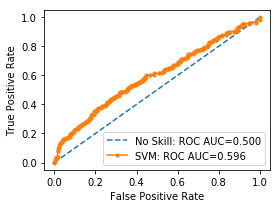

In [8]:
#trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=10)

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

clf = svm.SVC(kernel='poly', C=1, probability = True).fit(trainX, trainy)
print(clf.score(testX, testy))


lr_probs  = clf.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs  = lr_probs[:, 1]
### calculate scores
ns_auc    = roc_auc_score(testy, ns_probs)
lr_auc    = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

##RMSE,Acurry Scores
preds = clf.predict(testX)
rmse  = np.sqrt(mean_squared_error(testy, preds))
print("RMSE: %f" % (rmse))

# make predictions for test data
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy    = accuracy_score(testy, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# plot the roc curve for the model
fig,ax = plt.subplots(figsize = (4,3))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f' % (ns_auc))
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('results/SVM'+ featureName +'.pdf')
plt.show()
plt.close()

#print(preds)

In [36]:
##CV
accuracy = cross_val_score(clf, trainX, trainy, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.60714286 0.58571429 0.53571429 0.54285714 0.54285714 0.55714286
 0.49285714 0.57857143 0.43571429 0.49285714]
Accuracy of Model with Cross Validation is: 53.714285714285715


## Decision Tree

Accuracy: 67.83%
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.732


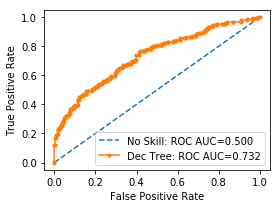

In [9]:
#https://www.datacamp.com/community/tutorials/xgboost-in-python

import xgboost as xgb


data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_class     = xgb.XGBClassifier()

eval_set     = [(testX, testy)]
xg_class.fit(trainX, trainy, eval_metric="auc", eval_set=eval_set, verbose=False);

preds        = xg_class.predict(testX)


# make predictions for test data
predictions  = [round(value) for value in preds]
# evaluate predictions
accuracy     = accuracy_score(testy, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

lr_probs     = xg_class.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs     = lr_probs[:, 1]
### calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)



# plot the roc curve for the model
fig,ax = plt.subplots(figsize = (4,3))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f' % (ns_auc))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Dec Tree: ROC AUC=%.3f' % (lr_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('results/DecisionTreeXGBoost'+ featureName +'.pdf')
plt.show()
plt.close()

#print(preds)

#### Cross validation

In [38]:
#CV1
accuracy = cross_val_score(xg_class, trainX, trainy, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.63571429 0.69285714 0.68571429 0.65       0.62142857 0.6
 0.6        0.70714286 0.60714286 0.57857143]
Accuracy of Model with Cross Validation is: 63.78571428571428


In [12]:
#CV2
cv_results = xgb.cv(dtrain=data_dmatrix, nfold=3,
                    num_boost_round=10,early_stopping_rounds=50,metrics="rmse", as_pandas=True, seed=123)

cv_results.head(10)
print((cv_results["test-rmse-mean"]).tail(1))


TypeError: cv() missing 1 required positional argument: 'params'

#### Plot Tree

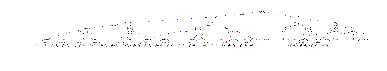

In [52]:
#xg_class = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=20)

plt.figsize=(50,10)
xgb.plot_tree(xg_class,num_trees=0,)
plt.savefig('Tree'+ featureName + '.pdf', dpi = 2000)
plt.show()

## Random Forest